# Import libraries and data


In [1]:
%cd D://Flood Risk Churn-MF/Evaluacion del dataset 25001 para validacion de articulo/25044

D:\Flood Risk Churn-MF\Evaluacion del dataset 25001 para validacion de articulo\25044


C:\Users\ZM\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
%pip install tensorflow_probability

In [2]:
#import libraries
import pandas as pd
import tensorflow_probability as tfp
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']=1.5
dark_style={
 'figure.facecolor':'#212946',
 'axes.facecolor':'#212946',
 'savefig.facecolor':'#212946',
 'axes.grid':True,
 'axes.grid.which':'both',
 'axes.spines.top':False,
 'axes.spines.bottom':False,
 'grid.color':'#2A3459',
 'grid.linewidth':'1',
 'text.color':'0.9',
 'axes.labelcolor':'0.9',
 'xtick.color':'0.9',
 'ytick.color':'0.9',
 'font.size':12
}
plt.rcParams.update(dark_style)

In [3]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.tbats import TBATS
from sktime.utils.plotting import plot_series

In [4]:

data = pd.read_csv("25044_mens.csv",
                   index_col="DATE",
                   parse_dates=True)
dataset = data.loc[:, ["Year","Month","EVAP","PRECIP","TMAX","TMIN"]]
dataset.head(1)   

#data = dataset[dataset.Year.isin( [1972,1973,1974,1975,1976,1977,1978,1979])]
data.head()

,Unnamed: 0,Year,Month,EVAP,PRECIP,TMAX,TMIN,DATE2
DATE,,,,,,,,
1961-01-01,0,1961,1,4.593548,144.0,33.5,9.0,1961-01-01
1961-02-01,1,1961,2,5.985714,0.0,38.5,5.5,1961-02-01
1961-03-01,2,1961,3,6.787097,0.0,43.5,7.5,1961-03-01
1961-04-01,3,1961,4,8.853333,0.0,44.5,8.0,1961-04-01
1961-05-01,4,1961,5,10.732258,0.0,51.0,14.0,1961-05-01


In [5]:
data.index = pd.to_datetime(data.index,
                            format = "%d/%m/%Y")
data.head(2)   
data = data.asfreq("MS")
data.index                     

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01',
               ...
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-03-01'],
              dtype='datetime64[ns]', name='DATE', length=627, freq='MS')

#Data Transformation

In [6]:
def metricas(y_true,y_pred,model_name):
    mae_=mean_absolute_error(y_true,y_pred)
    rmse_=mean_squared_error(y_true,y_pred,square_root=True)
    mape_=mean_absolute_percentage_error(y_true,y_pred)
    smape_=mean_absolute_percentage_error(y_true,y_pred,symmetric=True)
    dict_={'MAE':mae_,'RMSE_':rmse_,'MAPE':mape_,'SMAPE':smape_}
    metrica1=pd.DataFrame(dict_,index=[model_name])
    return(metrica1.round(decimals=2))

In [7]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['EVAP'],test_size=24)
y_train1, y_test1=temporal_train_test_split(data['EVAP'],test_size=24)
y_train.head(10)

DATE
1961-01-01     4.593548
1961-02-01     5.985714
1961-03-01     6.787097
1961-04-01     8.853333
1961-05-01    10.732258
1961-06-01    10.570000
1961-07-01     7.787097
1961-08-01     6.887097
1961-09-01     5.520000
1961-10-01     6.054839
Freq: MS, Name: EVAP, dtype: float64

#Regressors

In [65]:
#get a library
import tensorflow_probability as tfp

In [8]:
#Isolate the regressors
data=data.loc[:,['PRECIP','EVAP','TMAX','TMIN']]
exog = np.asmatrix(data.iloc[:,:].astype(np.float64))
exog[:1]
#exog=np.asmatrix(data['PRECIP'])
#exog[:1]

matrix([[144.        ,   4.59354839,  33.5       ,   9.        ]])

In [ ]:
%pip install --upgrade tensorflow
%pip install tensorflow-probability[tf]
%pip install --upgrade pip

In [9]:
#linear regression
regressors = tfp.sts.LinearRegression(design_matrix = exog,
                                      name = "regressors")

#Seasonality

In [10]:
#isolating dependent variable
y = y_train.astype(np.float64)
y[:5]

DATE
1961-01-01     4.593548
1961-02-01     5.985714
1961-03-01     6.787097
1961-04-01     8.853333
1961-05-01    10.732258
Freq: MS, Name: EVAP, dtype: float64

In [11]:
#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effect")

In [70]:
#number of days per month
num_days_per_month = np.array(
    [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
     [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) # 2012

In [12]:
#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = 12,
                                  observed_time_series = y,
                                  name = "monthly_effect")

#Autoregressive and Trend components

In [13]:
#trend 
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")

In [14]:
#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

#Tensorflow Structural Time series

In [15]:
#forecasting model
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

In [16]:
#fit with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

In [76]:
#forecast
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(y_test))

In [77]:
#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = y_test.index
predictions_tfp[:2]

FECHA
1978-01-01    5.262376
1978-02-01    6.069631
Freq: MS, Name: TFP, dtype: float64

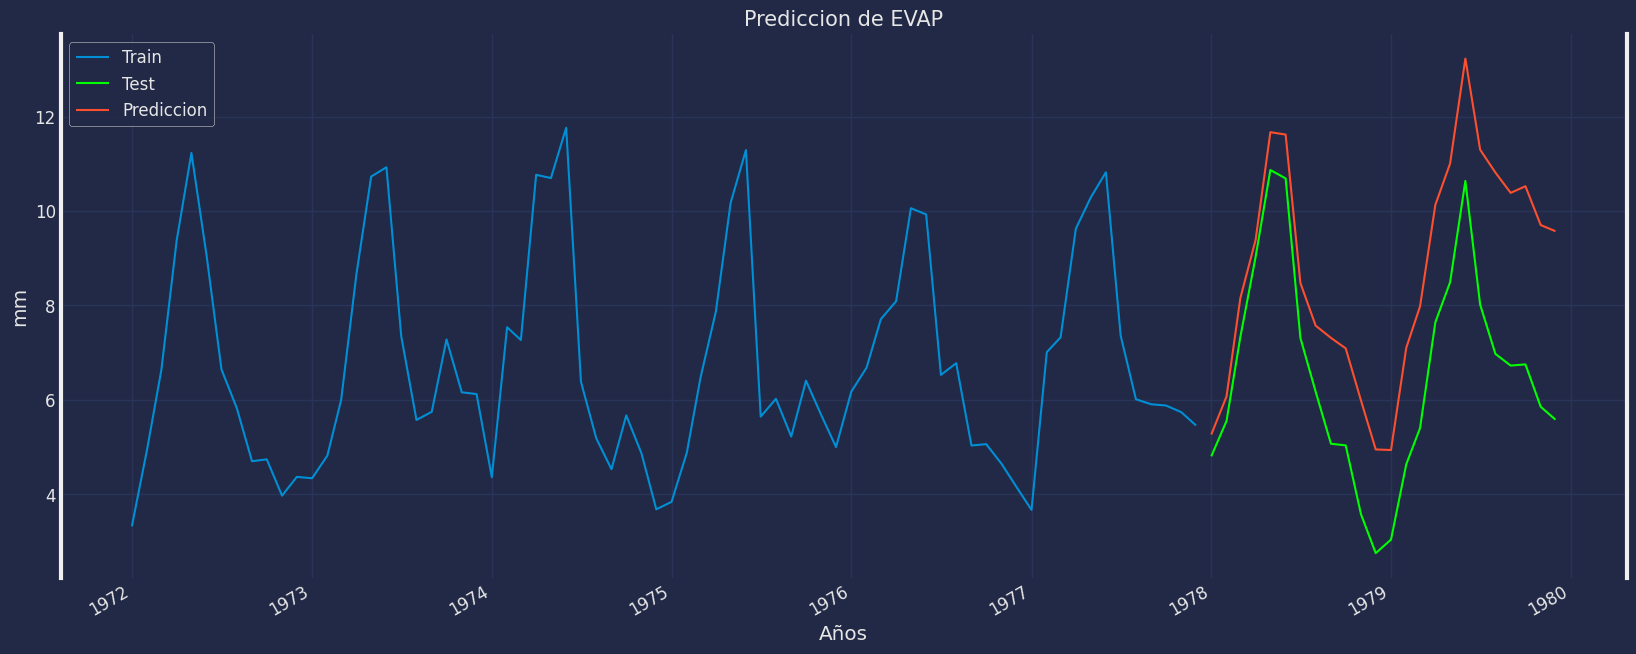

In [78]:
#visualization

plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de EVAP",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

In [79]:
B=metricas(y_test,predictions_tfp,"TF KEras").T
B

,TF KEras
MAE,2.18
RMSE_,2.46
MAPE,0.38
SMAPE,0.30


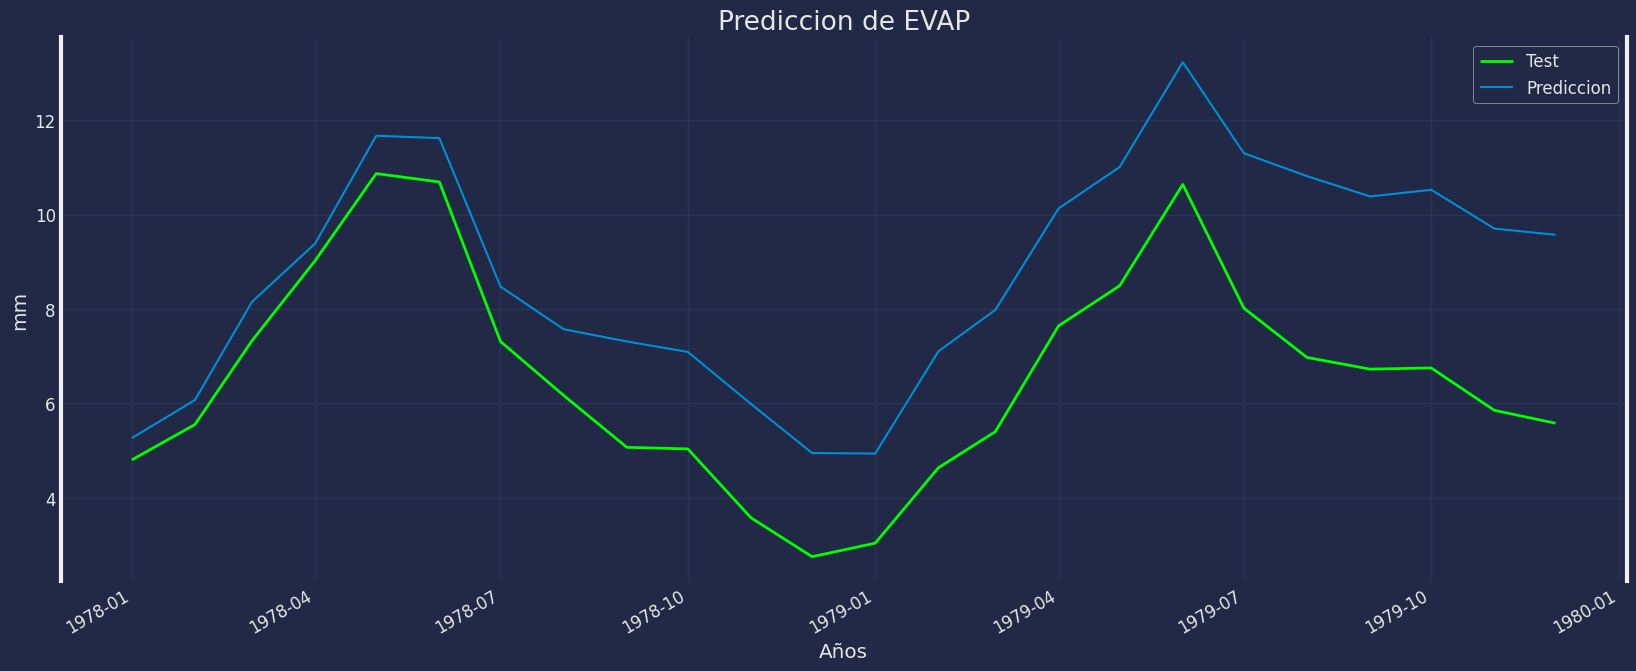

In [80]:
plt.figure(figsize=(18, 8))
plt.plot(y_test,color="Lime",linewidth=2,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de EVAP",fontsize=19)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

#Model assessment

In [52]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(y_test, predictions_tfp),0))
print(round(np.sqrt(mean_squared_error(y_test, predictions_tfp)), 0))

1.0
1.0


#export forecasts

In [29]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble


In [30]:
predictions_tfp.to_csv('predictions_tfp.csv', index = True)

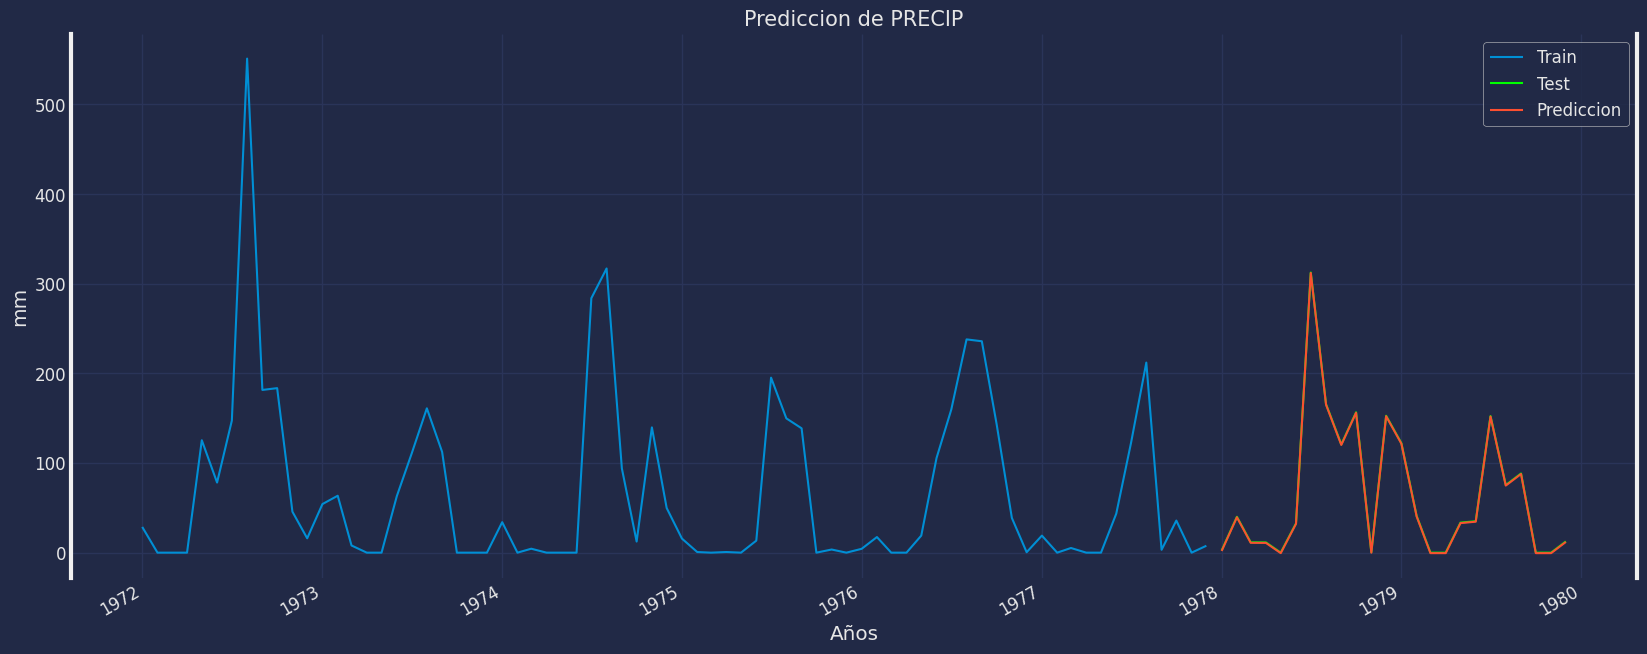

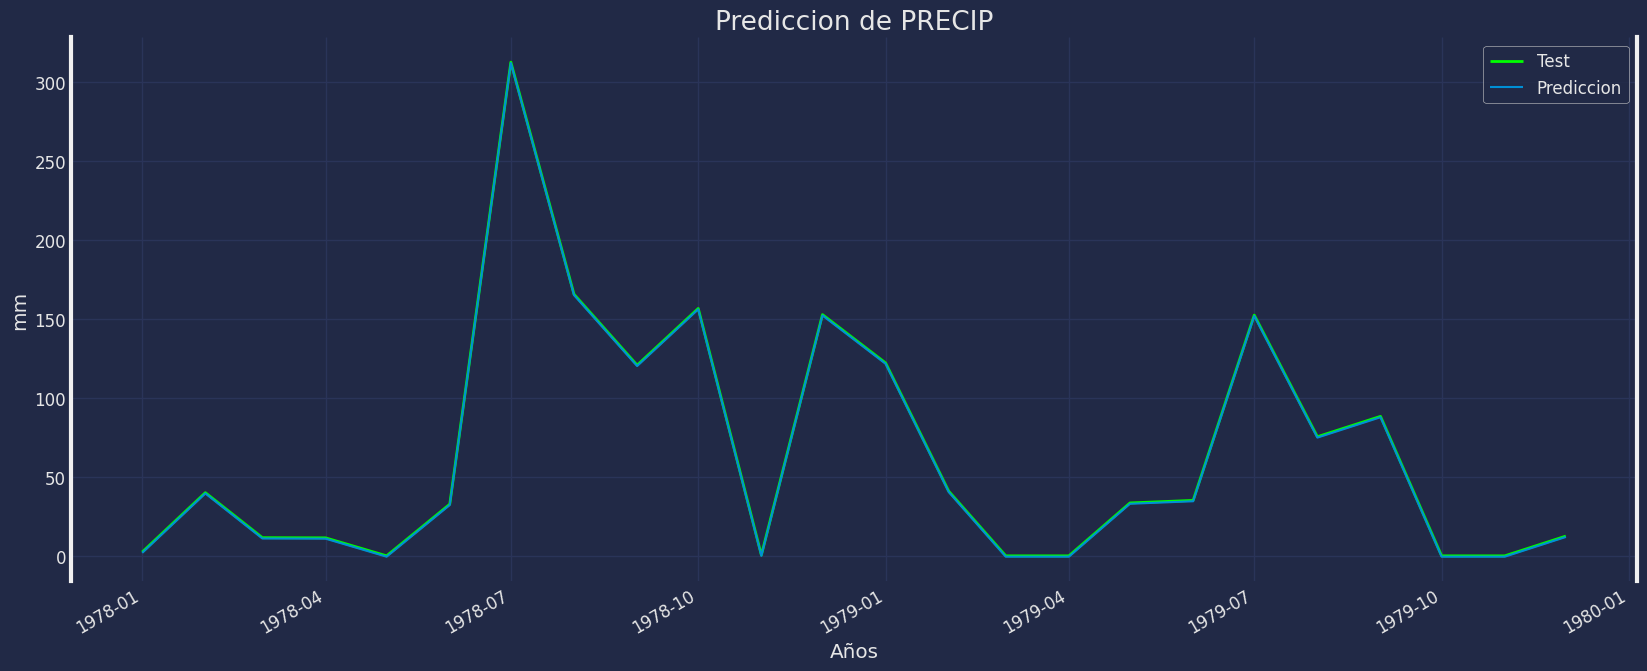

,TF
MAE,5.300000e-01
RMSE_,5.300000e-01
MAPE,4.983639e+14
SMAPE,5.200000e-01


In [81]:
# Predicciones de la variable EVAP

from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['PRECIP'],test_size=24)
y_train1, y_test1=temporal_train_test_split(data['PRECIP'],test_size=24)
y_train.head(10)

#Isolate the regressors
data=data.loc[:,['PRECIP','EVAP','TMAX','TMIN']]
exog = np.asmatrix(data.iloc[:,:].astype(np.float64))
exog[:1]
#exog=np.asmatrix(data['PRECIP'])
#exog[:1]

#linear regression
regressors = tfp.sts.LinearRegression(design_matrix = exog,
                                      name = "regressors")

#isolating dependent variable
y = y_train.astype(np.float64)
y[:5]

#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effect")

#number of days per month
num_days_per_month = np.array(
    [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
     [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) # 2012

#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = 12,
                                  observed_time_series = y,
                                  name = "monthly_effect")

#trend 
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")

#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

#forecasting model
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

#fit with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

#forecast
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(y_test))

#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = y_test.index
predictions_tfp[:2]

#visualization

plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de PRECIP",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()
plt.figure(figsize=(18, 8))
plt.plot(y_test,color="Lime",linewidth=2,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de PRECIP",fontsize=19)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()
B=metricas(y_test,predictions_tfp,"TF").T
B

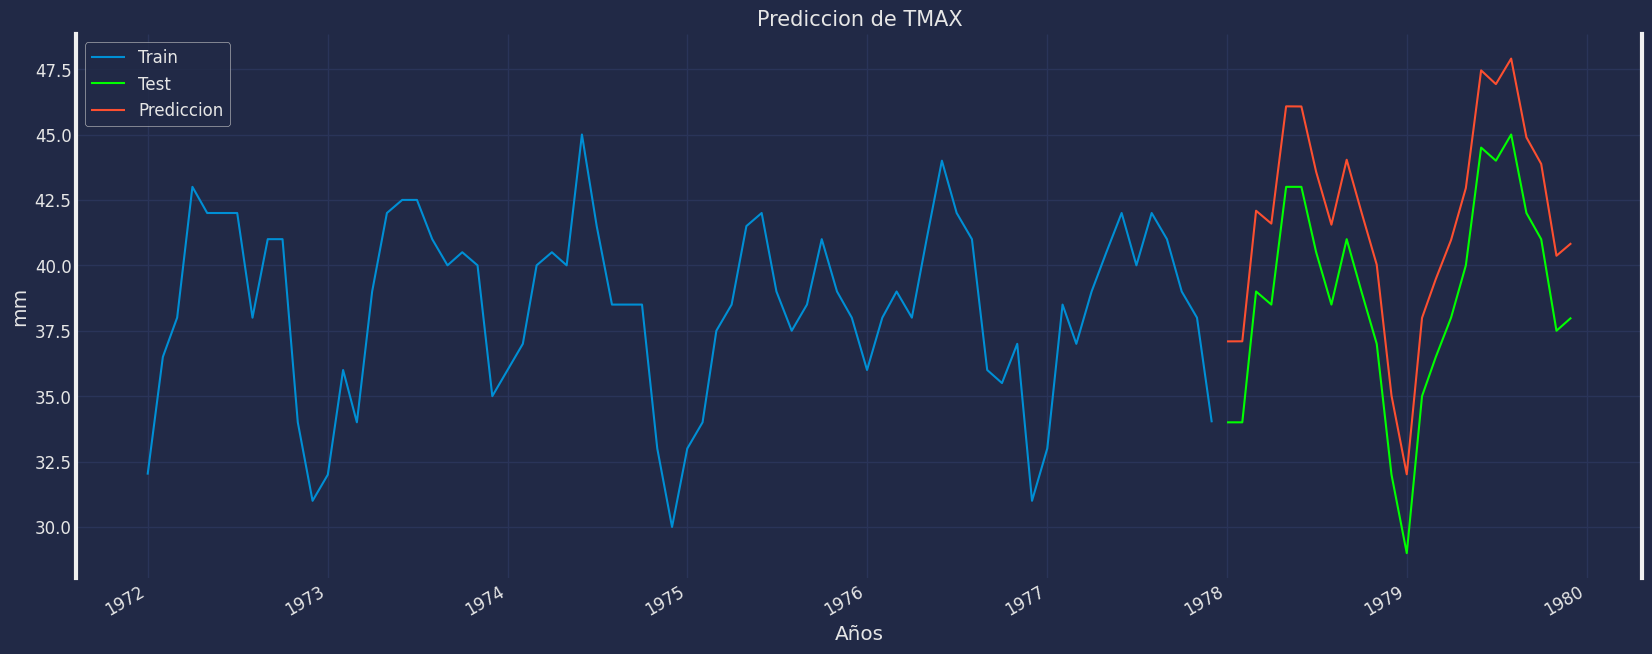

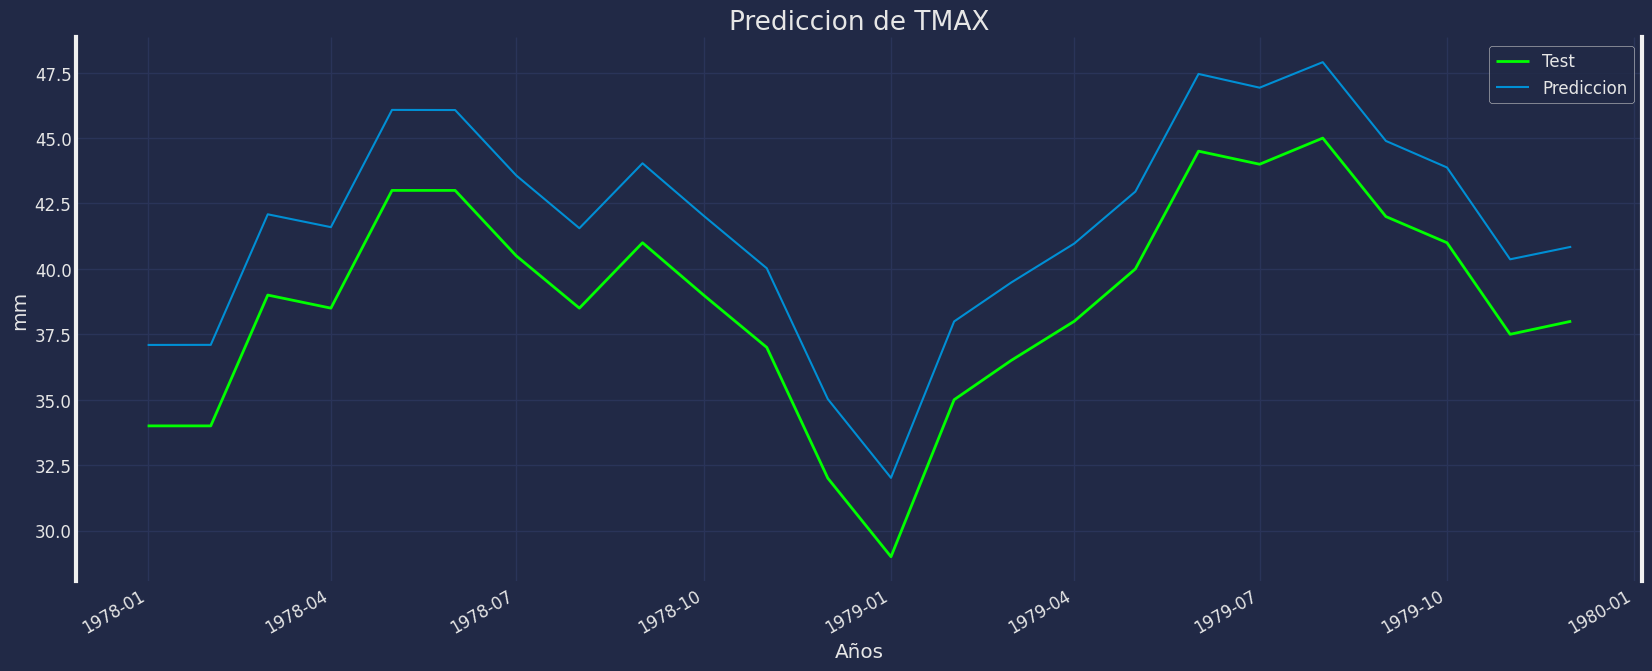

,TF
MAE,3.00
RMSE_,3.00
MAPE,0.08
SMAPE,0.08


In [82]:
# Predicciones de la variable EVAP

from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['TMAX'],test_size=24)
y_train1, y_test1=temporal_train_test_split(data['TMAX'],test_size=24)
y_train.head(10)

#Isolate the regressors
data=data.loc[:,['PRECIP','EVAP','TMAX','TMIN']]
exog = np.asmatrix(data.iloc[:,:].astype(np.float64))
exog[:1]
#exog=np.asmatrix(data['PRECIP'])
#exog[:1]

#linear regression
regressors = tfp.sts.LinearRegression(design_matrix = exog,
                                      name = "regressors")

#isolating dependent variable
y = y_train.astype(np.float64)
y[:5]

#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effect")

#number of days per month
num_days_per_month = np.array(
    [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
     [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) # 2012

#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = 12,
                                  observed_time_series = y,
                                  name = "monthly_effect")

#trend 
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")

#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

#forecasting model
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

#fit with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

#forecast
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(y_test))

#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = y_test.index
predictions_tfp[:2]

#visualization

plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de TMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()
plt.figure(figsize=(18, 8))
plt.plot(y_test,color="Lime",linewidth=2,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de TMAX",fontsize=19)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()
B=metricas(y_test,predictions_tfp,"TF").T
B

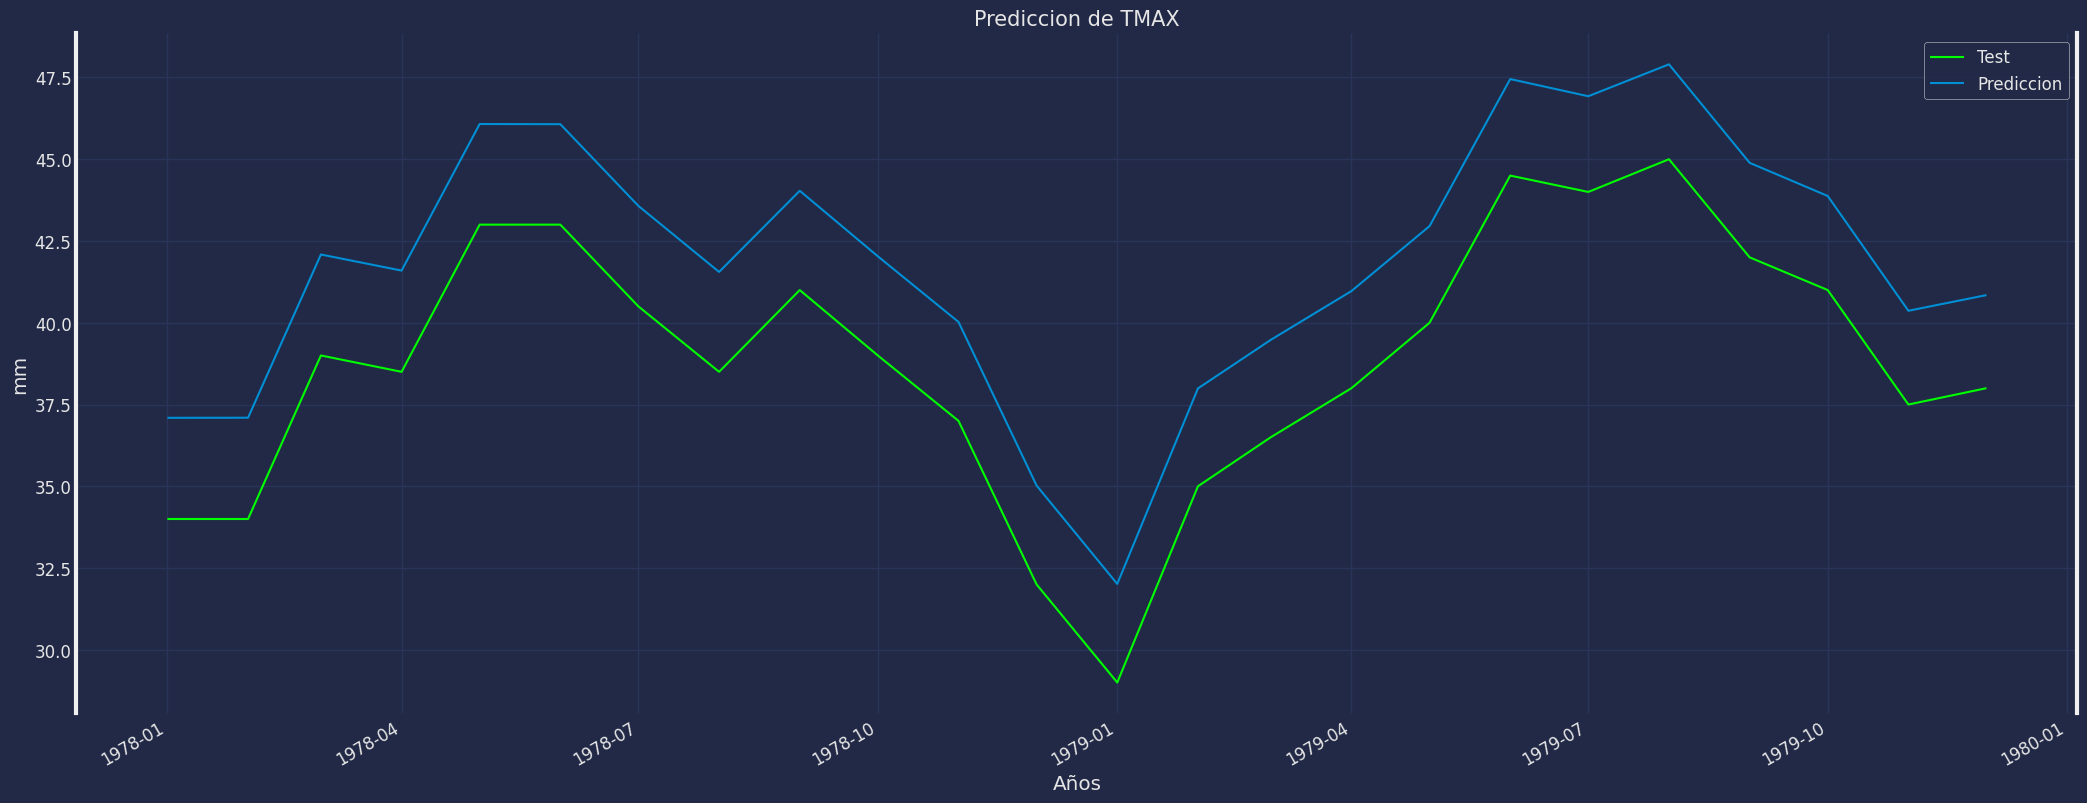

In [83]:
plt.figure(figsize=(23, 10))

plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de TMAX",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

In [84]:
B=metricas(y_test,predictions_tfp,"TF KEras").T
B

,TF KEras
MAE,3.00
RMSE_,3.00
MAPE,0.08
SMAPE,0.08


: 

In [85]:
# Predicciones de la variable TMIN
from sktime.forecasting.model_selection import temporal_train_test_split
y_train,y_test=temporal_train_test_split(data['TMIN'],test_size=36)
y_train1, y_test1=temporal_train_test_split(data['TMIN'],test_size=36)
print(y_train.head(10))

#Isolate the regressors
data=data.loc[:,['PRECIP','EVAP','TMAX','TMIN']]
exog = np.asmatrix(data.iloc[:,:].astype(np.float64))
print(exog[:1])
#exog=np.asmatrix(data['PRECIP'])
#exog[:1]

#linear regression
regressors = tfp.sts.LinearRegression(design_matrix = exog,
                                      name = "regressors")

#isolating dependent variable
y = y_train.astype(np.float64)
print(y[:5])

#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effect")

#number of days per month
num_days_per_month = np.array(
    [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
     [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) # 2012

#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = 12,
                                  observed_time_series = y,
                                  name = "monthly_effect")

#trend 
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")

#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

#forecasting model
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

#fit with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

#forecast
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(y_test))

#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = y_test.index
predictions_tfp[:2]

#visualization

plt.figure(figsize=(18, 8))
plt.plot(y_train,label="Train")
plt.plot(y_test,color="Lime",linewidth=1.5,label="Test")
predictions_tfp.plot(legend = True, label="Prediccion")
plt.title("Prediccion de TMIN",fontsize=15)
plt.xlabel("Años")
plt.ylabel("mm")
plt.legend()
plt.show()

B=metricas(y_test,predictions_tfp,"TF KEras").T
print(B)

FECHA
1972-01-01     9.0
1972-02-01     6.0
1972-03-01     8.5
1972-04-01    10.0
1972-05-01    14.5
1972-06-01    20.5
1972-07-01    20.5
1972-08-01    21.0
1972-09-01    16.0
1972-10-01    16.5
Freq: MS, Name: TMIN, dtype: float64
[[28.7         3.31612903 32.          9.        ]]
FECHA
1972-01-01     9.0
1972-02-01     6.0
1972-03-01     8.5
1972-04-01    10.0
1972-05-01    14.5
Freq: MS, Name: TMIN, dtype: float64
